# nn

> Lightweight neural network implementation on top of Value autograd framework

In [ ]:
#| default_exp nn

In [ ]:
#| hide
from nbdev.showdoc import *

In [44]:
#| export
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
from minion.core import Value
import random
from typing import List

In [45]:
#| hide
from minion.utils import draw_dot
from IPython.display import SVG, display

In [46]:
%matplotlib inline

In [63]:
#| export 

class Module(object):
    def __init__(self) -> None:
        pass

    def num_params(self):
        return len(self.parameters())
    
    def parameters(self):
        pass
    # def __repr__(self) -> str:
    #     return "This is a minion module"

In [64]:
Module()

## Neuron Implementation

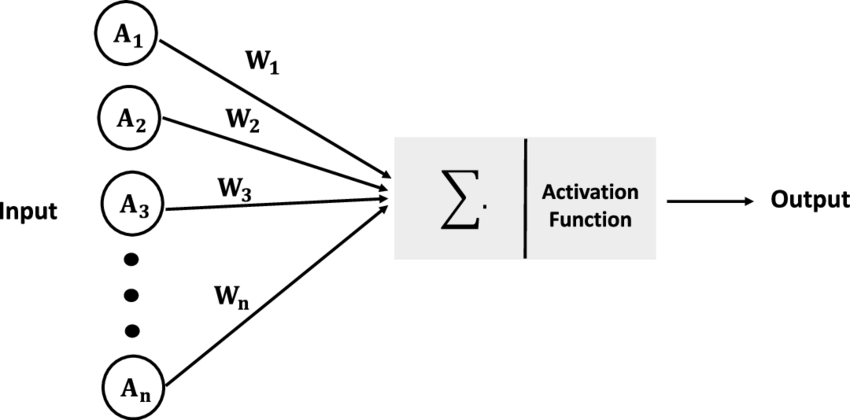

In [75]:
#| export
class Neuron(Module):
    def __init__(self, nin) -> None:
        super().__init__()
        self.weights = [Value(random.random()) for _ in range(nin)]
        self.bias = Value(random.random())

    def __call__(self, xs) -> Value:
        out = sum((w*x for w,x in zip(self.weights, xs)), self.bias)
        return out.tanh()
    
    def parameters(self):
        return self.weights + [self.bias]


In [76]:
xs = [1, 2, 3, 4]

n = Neuron(len(xs))
n(xs)


Value(data=0.9999940015539884)

In [77]:
n.parameters()

[Value(data=0.23180300732490444),
 Value(data=0.8983613842118221),
 Value(data=0.6676595058931537),
 Value(data=0.4317152406697309),
 Value(data=0.6002118947430582)]

## Layer Implementation

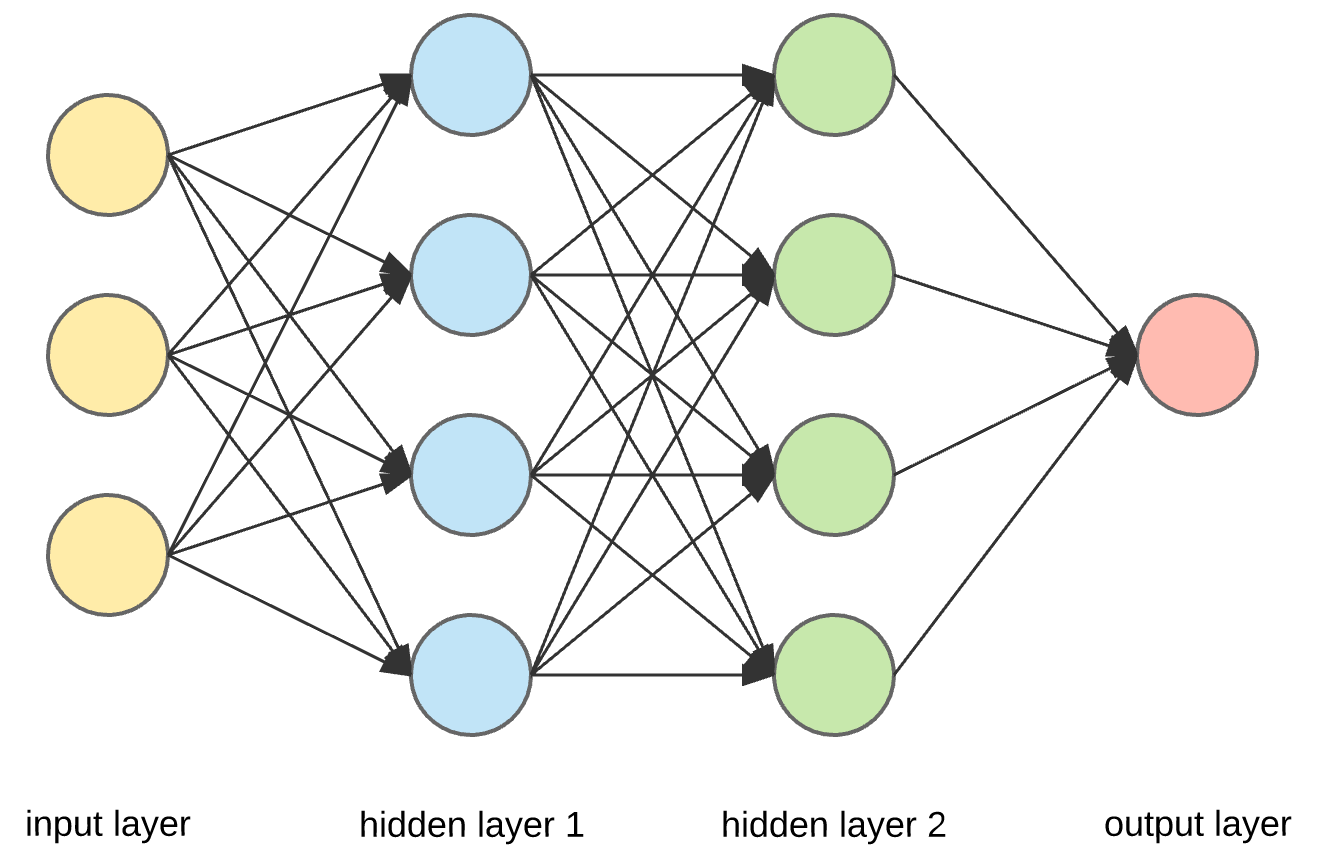

In [107]:
#| export
class Layer(Module):

    def __init__(self, nin, nout) -> None:
        super().__init__()
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, xs) -> List[Value]:
        ys = [neuron(xs) for neuron in self.neurons]
        return ys
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


In [108]:
xs = [1, 2, 3, 4]

l = Layer(len(xs), 3)
l(xs)

[Value(data=0.9995971357227623),
 Value(data=0.9955138580272502),
 Value(data=0.9999770836484165)]

In [109]:
# len(l.parameters()), l.parameters()
l.num_params(), l.parameters()

(15,
 [Value(data=0.9232075534049726),
  Value(data=0.04513668135792348),
  Value(data=0.5654164719032143),
  Value(data=0.17358722658144488),
  Value(data=0.8508490428036887),
  Value(data=0.4414936983948725),
  Value(data=0.20521300875749626),
  Value(data=0.27723946205566563),
  Value(data=0.3259940401530943),
  Value(data=0.061217630083876484),
  Value(data=0.4688135627285891),
  Value(data=0.7449661610037545),
  Value(data=0.6163881456317651),
  Value(data=0.35317976960336905),
  Value(data=0.4677683907471394)])

## Multilayer Perceptron implementation

In [110]:
#| export

class MLP(Module):
    def __init__(self, nin, nouts) -> None:
        super().__init__()
        self.layers = [Layer(lin, lout) for lin,lout in zip([nin]+nouts[:-1], nouts)]

    def __call__(self, xs):
        x = xs
        for layer in self.layers:
            x = layer(x)
        return x[0] if len(x) ==1 else x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [120]:
nin = len(xs)
nouts = [3,4,4,1]
# for lin,lout in zip([nin]+nouts[:-1], nouts):
#     print(lin, lout)

mlp = MLP(nin, nouts)
mlp(xs), mlp.num_params()

(Value(data=0.9954656165214806), 56)

In [121]:
#| hide
import nbdev; nbdev.nbdev_export()